In [1]:
import GEMVAE

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
file = r'data\Breast_Cancer(Spots)'
dir = r'GSE198353_mmtv_pymt_GEX_filtered_feature_bc_matrix.h5'
gdata = sc.read_visium(file, count_file=dir,load_images=True)
gdata.var_names_make_unique()
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
dir = r'data\Breast_Cancer(Spots)\GSE198353_mmtv_pymt_ADT_t.csv'
pdata = sc.read_csv(dir)
pdata.var_names_make_unique()
pdata

AnnData object with n_obs × n_vars = 1978 × 32

In [5]:
pdata.obsm=gdata.obsm
pdata.uns = gdata.uns
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# gdata.obsm=adata.obsm
# gdata.uns = adata.uns
# pdata.obsm=adata.obsm
# pdata.uns = adata.uns

In [7]:
#Normalization Gene
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=2200)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

#Normalization Protein 
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

------Calculating spatial graph...
The graph contains 11434 edges, 1978 cells.
5.7806 neighbors per cell on average.


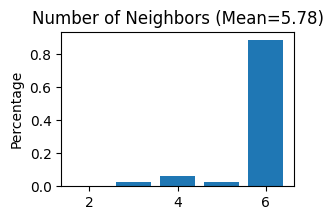

In [8]:
GEMVAE.Cal_Spatial_Net(gdata, rad_cutoff=100)
GEMVAE.Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 11434 edges, 1978 cells.
5.7806 neighbors per cell on average.


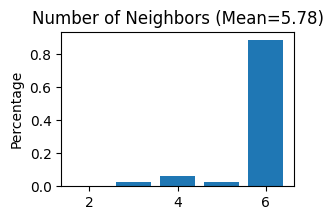

In [9]:
GEMVAE.Cal_Spatial_Net(pdata, rad_cutoff=100)
GEMVAE.Stats_Spatial_Net(pdata)

In [10]:
# hyper parameters 
epochs = 400
hidden_dims_gene = [512,30]
hidden_dims_pro = [128, 30]

#cell-type aware params
alpha = 0
pre_resolution_gene = 0
pre_resolution_pro = 0
save_loss = True

# Loss weights
kl_loss = 0
contrastive_loss = 10
weight_decay_loss = 1      #Loss for Ateentions Layers
recon_loss_type = 'ZINB'      # ZINB or MSE
recon_loss = 1

In [11]:
trained_gdata = GEMVAE.train_GEMVAE(gdata,pdata,n_epochs=epochs,hidden_dims1=hidden_dims_gene,hidden_dims2=hidden_dims_pro,
                                    alpha=alpha,pre_resolution1=pre_resolution_gene,pre_resolution2=pre_resolution_pro, save_loss=save_loss,
                                    kl_loss = kl_loss,
                                    contrastive_loss = contrastive_loss,
                                    weight_decay_loss = weight_decay_loss,       
                                    recon_loss_type = recon_loss_type,   
                                    recon_loss = recon_loss)

Size of Input for gene data :  (1978, 2200)
Size of Input for protein data :  (1978, 32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loss weights are =  10 1 1 0


Alpha = 0
START TRAIN
Epoch: 0, Contrastive Loss: 9.2456, Loss: 4457.7422
Epoch: 1, Contrastive Loss: 8.9653, Loss: 4445.7739
Epoch: 2, Contrastive Loss: 8.7860, Loss: 4428.4590
Epoch: 3, Contrastive Loss: 8.6796, Loss: 4421.4448
Epoch: 4, Contrastive Loss: 8.6138, Loss: 4411.3442
Epoch: 5, Contrastive Loss: 8.5677, Loss: 4403.1875
Epoch: 6, Contrastive Loss: 8.5304, Loss: 4405.4004
Epoch: 7, Contrastive Loss: 8.4997, Loss: 4400.2510
Epoch: 8, Contrastive Loss: 8.4748, Loss: 4389.7598
Epoch: 9, Contrastive Loss: 8.4559, Loss: 4376.9961
Epoch: 10, Contrastive Loss: 8.4430, Loss: 4378.4561
Epoch: 11, Contrastive Loss: 8.4354, Loss: 4372.2026
Epoch: 12, Contrastive Loss: 8.4326, Loss: 43

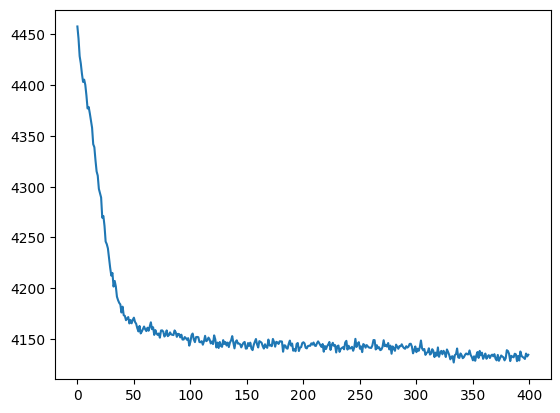

In [12]:
plt.plot(trained_gdata.uns['arch_loss'])
plt.show()

In [13]:
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]

In [14]:
#DEFINE THE NUMBER OF CLUSTERS HERE
n_clusters = 4

In [15]:
for tool in ['mclust','leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print("Using tool : ",tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'])

   # clustering
   if tool == 'mclust':
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=n_clusters, method=tool)
   elif tool in ['leiden']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.1)
   elif tool in ['louvain']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.05)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



Using tool :  mclust
fitting ...
  |======================================================================| 100%
Using tool :  leiden
Searching resolution...
resolution=1.2100000000000002, cluster number=16
resolution=1.11, cluster number=15
resolution=1.01, cluster number=14
resolution=0.91, cluster number=14
resolution=0.81, cluster number=14
resolution=0.7100000000000001, cluster number=14
resolution=0.6100000000000001, cluster number=10
resolution=0.51, cluster number=9
resolution=0.41000000000000003, cluster number=8
resolution=0.31000000000000005, cluster number=7
resolution=0.21000000000000002, cluster number=6
resolution=0.11, cluster number=5
resolution=0.01, cluster number=1


AssertionError: Resolution is not found. Please try bigger range or smaller step!.

Visualizing the clusters

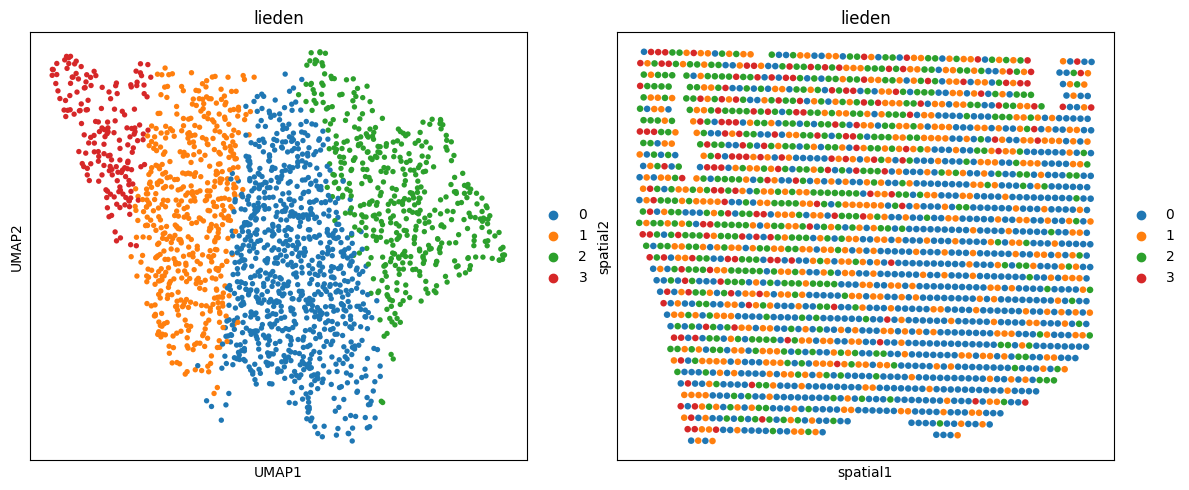

In [ ]:
# visualization lieden
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='lieden', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='lieden', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

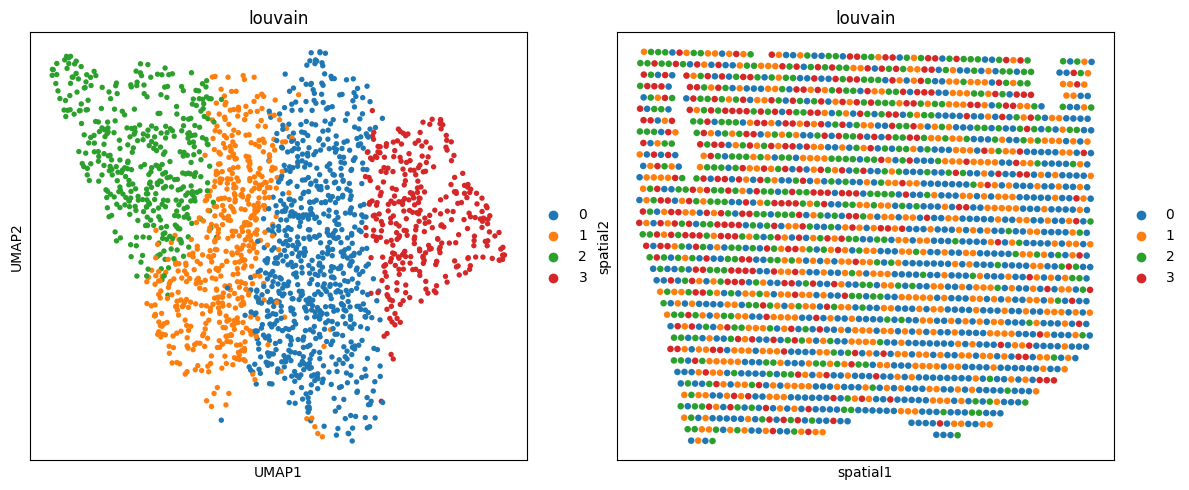

In [ ]:
# visualization louven
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='3', ax=ax_list[0], title='louvain', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='3', ax=ax_list[1], title='louvain', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

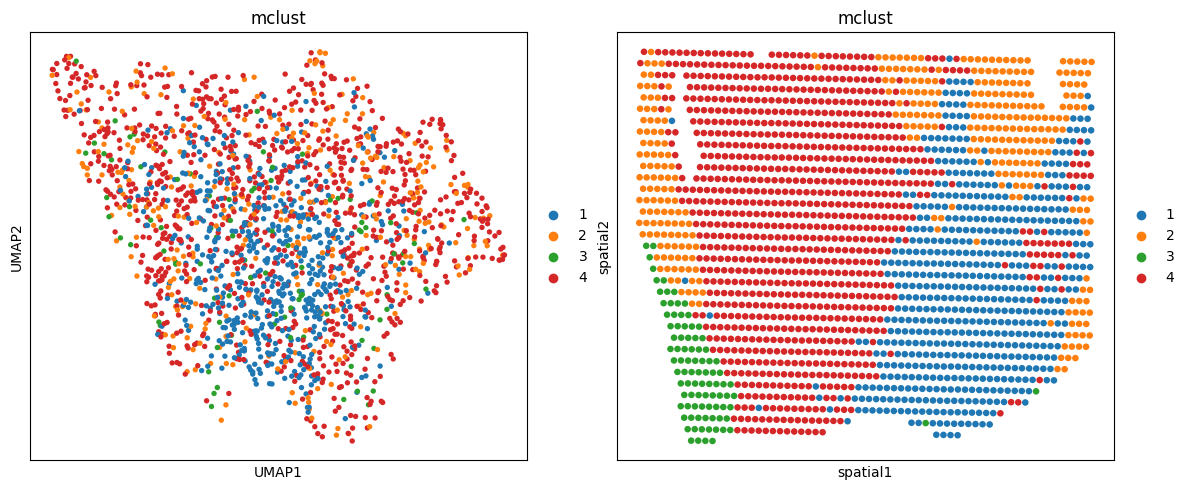

In [ ]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()